In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from numpy.random import seed

sns.set(color_codes=True)
%matplotlib inline
print(tf.__version__)
assert(tf.__version__ >= '2.')

2.7.0


In [3]:
FILE_NAME = "physionet2017.csv"
data = pd.read_csv(FILE_NAME)
data = data.sample(frac=1)
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,name,label
1998,0.184290,0.163142,0.154079,0.148036,0.145015,0.138973,0.129909,0.123867,0.123867,0.126888,0.132931,0.138973,0.141994,0.148036,0.148036,0.141994,0.129909,0.120846,0.111782,0.105740,0.096677,0.087613,0.075529,0.057402,0.042296,0.015106,-0.072508,-0.199396,-0.383686,-0.634441,-0.945619,-1.314199,-1.709970,-2.066465,-2.223565,-2.190332,-1.845921,-1.163142,-0.347432,0.377644,...,-0.235650,-0.229607,-0.223565,-0.211480,-0.196375,-0.181269,-0.154079,-0.090634,-0.036254,0.003021,0.033233,0.045317,0.054381,0.060423,0.063444,0.066465,0.072508,0.078550,0.081571,0.081571,0.081571,0.084592,0.084592,0.084592,0.087613,0.087613,0.084592,0.081571,0.081571,0.081571,0.081571,0.084592,0.084592,0.081571,0.081571,0.081571,0.081571,0.081571,A01/A01999,2
3148,0.048276,0.041379,0.027586,0.013793,0.006897,0.000000,0.000000,-0.006897,-0.027586,-0.041379,-0.041379,-0.013793,0.020690,0.068966,0.131034,0.165517,0.186207,0.200000,0.213793,0.220690,0.206897,0.172414,0.137931,0.124138,0.110345,0.096552,0.089655,0.075862,0.068966,0.062069,0.062069,0.055172,0.048276,0.041379,0.034483,0.034483,0.027586,0.020690,0.013793,0.006897,...,0.365517,0.358621,0.358621,0.351724,0.331034,0.310345,0.289655,0.262069,0.227586,0.151724,0.075862,0.000000,-0.103448,-0.220690,-0.310345,-0.372414,-0.441379,-0.468966,-0.448276,-0.365517,-0.131034,0.144828,0.455172,0.662069,0.737931,0.731034,0.613793,0.441379,0.248276,0.096552,-0.062069,-0.200000,-0.289655,-0.275862,-0.158621,-0.124138,-0.117241,-0.103448,A03/A03149,3
5058,0.014264,0.018018,0.021021,0.024775,0.028529,0.031532,0.034535,0.036787,0.042793,0.051051,0.056306,0.060060,0.055556,0.052553,0.050300,0.048048,0.045796,0.042793,0.039790,0.037538,0.036036,0.034535,0.033033,0.032282,0.030781,0.029279,0.027027,0.025526,0.024024,0.022523,0.021772,0.020270,0.019520,0.018769,0.017267,0.015766,0.014264,0.013514,0.012763,0.011261,...,-0.126126,-0.120120,-0.117117,-0.114865,-0.114114,-0.113363,-0.113363,-0.112613,-0.111111,-0.109610,-0.116366,-0.122372,-0.127628,-0.129880,-0.126877,-0.120871,-0.113363,-0.105105,-0.100601,-0.095345,-0.085586,-0.077327,-0.073574,-0.069820,-0.066817,-0.064565,-0.062312,-0.057057,-0.045796,-0.036036,-0.030030,-0.025526,-0.021772,-0.018018,-0.011261,-0.001502,0.005255,0.010511,A05/A05059,1
2908,0.133152,0.157609,0.191576,0.230978,0.264946,0.289402,0.297554,0.302989,0.307065,0.311141,0.312500,0.311141,0.304348,0.297554,0.290761,0.285326,0.278533,0.271739,0.260870,0.250000,0.237772,0.222826,0.203804,0.203804,0.221467,0.232337,0.240489,0.248641,0.254076,0.258152,0.259511,0.255435,0.250000,0.243207,0.236413,0.230978,0.225543,0.218750,0.211957,0.205163,...,-0.362772,-0.362772,-0.361413,-0.360054,-0.357337,-0.354620,-0.351902,-0.349185,-0.345109,-0.334239,-0.323370,-0.312500,-0.302989,-0.294837,-0.286685,-0.277174,-0.269022,-0.259511,-0.248641,-0.237772,-0.224185,-0.214674,-0.205163,-0.197011,-0.192935,-0.192935,-0.197011,-0.201087,-0.206522,-0.209239,-0.216033,-0.218750,-0.210598,-0.195652,-0.158967,-0.116848,-0.062500,-0.001359,A02/A02909,0
5089,0.170624,0.175901,0.182058,0.189094,0.194371,0.200528,0.204925,0.209323,0.214600,0.219877,0.223395,0.223395,0.220756,0.216359,0.209323,0.197889,0.175901,0.153914,0.129288,0.108179,0.092348,0.074758,0.060686,0.048373,0.036060,0.025506,0.017590,0.012313,0.007036,0.000880,-0.003518,-0.009675,-0.014072,-0.015831,-0.018470,-0.021108,-0.023747,-0.027265,-0.029903,-0.031662,...,0.069481,0.071240,0.072120,0.072999,0.074758,0.076517,0.078276,0.079156,0.080035,0.081794,0.082674,0.084433,0.086192,0.088830,0.092348,0.097625,0.109938,0.121372,0.133685,0.146878,0.160070,0.177661,0.197889,0.207564,0.212841,0.217238,0.219877,0.221636,0.221636,0.219877,0.216359,0.211082,0.2

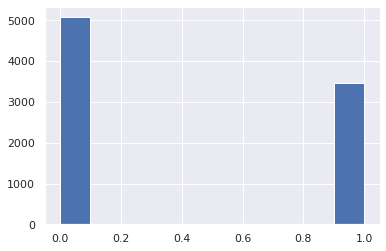

In [4]:
data.loc[data.label != 0, "label"] = 1
data['label'].hist();

In [5]:
X = data.iloc[:, :2000]
Y = data.iloc[:, 2001]
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.1, random_state=42)
print('X_train: ', X_train.shape)
print('X_valid: ', X_valid.shape)
X_train = np.expand_dims(X_train, axis = 2)
X_valid = np.expand_dims(X_valid, axis = 2)

X_train:  (7675, 2000)
X_valid:  (853, 2000)


In [6]:
def build_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv0 = keras.layers.Conv1D(filters=32, kernel_size=5, padding="same", activation = "relu")(input_layer)
    conv0 = keras.layers.MaxPooling1D(pool_size=2)(conv0)
    
    conv1 = keras.layers.Conv1D(filters=32, kernel_size=5, padding="same", activation="relu")(conv0)
    conv1 = keras.layers.MaxPooling1D(pool_size=2)(conv1)
    
    conv2 = keras.layers.Conv1D(filters=64, kernel_size=5, padding="same", activation="relu")(conv1)
    conv2 = keras.layers.MaxPooling1D(pool_size=2)(conv2)
    
    conv3 = keras.layers.Conv1D(filters=64, kernel_size=5, padding="same", activation="relu")(conv2)
    conv3 = keras.layers.MaxPooling1D(pool_size=2)(conv3)
    
    conv4 = keras.layers.Conv1D(filters=128, kernel_size=5, padding="same", activation="relu")(conv3)
    conv4 = keras.layers.MaxPooling1D(pool_size=2)(conv4)
    
    conv5 = keras.layers.Conv1D(filters=128, kernel_size=5, padding="same", activation="relu")(conv4)
    conv5 = keras.layers.MaxPooling1D(pool_size=2)(conv5)
    conv5 = keras.layers.Dropout(0.5)(conv5)
    
    conv6 = keras.layers.Conv1D(filters=256, kernel_size=5, padding="same", activation="relu")(conv5)
    conv6 = keras.layers.MaxPooling1D(pool_size=2)(conv6)
    
    conv7 = keras.layers.Conv1D(filters=256, kernel_size=5, padding="same", activation="relu")(conv6)
    conv7 = keras.layers.MaxPooling1D(pool_size=2)(conv7)
    conv7 = keras.layers.Dropout(0.5)(conv7)
    
    conv8 = keras.layers.Conv1D(filters=512, kernel_size=5, padding="same", activation="relu")(conv7)
    conv8 = keras.layers.MaxPooling1D(pool_size=2)(conv8)
    conv8 = keras.layers.Dropout(0.5)(conv8)
    
    conv9 = keras.layers.Conv1D(filters=512, kernel_size=5, padding="same", activation="relu")(conv8)
    
    gap = keras.layers.Flatten()(conv9)
    dense1 = keras.layers.Dense(64, activation = "relu")(gap)
    dense2 = keras.layers.Dropout(0.5)(dense1)
    dense3 = keras.layers.Dense(32, activation = "relu")(dense2)
    
    output_layer = keras.layers.Dense(1, activation="sigmoid")(dense3)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)
    
    return model

In [7]:
seed(1234)
tf.random.set_seed(1234)

In [8]:
model = build_model(input_shape=(2000, 1))
opt = keras.optimizers.Adam(learning_rate=0.00006)
mc = tf.keras.callbacks.ModelCheckpoint(
        'ecg5000.h5', monitor='val_loss', verbose=1, save_best_only=True,
        save_weights_only=True, mode='min', save_freq='epoch')
model.compile(
    optimizer=opt,
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 2000, 32)          192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1000, 32)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1000, 32)          5152      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 500, 32)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 500, 64)           10304 

In [9]:
NUM_EPOCHS = 100
BATCH_SIZE = 128
VAL_SPLIT = 0.2
VERBOSE = 1

import time

t_start = time.time()

history = model.fit(X_train, y_train, batch_size = BATCH_SIZE, epochs = NUM_EPOCHS, validation_split = VAL_SPLIT, verbose = VERBOSE)

Epoch 1/100
48/48 [==============================] - 96s 2s/step - loss: 0.6814 - accuracy: 0.5946 - val_loss: 0.6808 - val_accuracy: 0.5974
Epoch 2/100
48/48 [==============================] - 96s 2s/step - loss: 0.6752 - accuracy: 0.5946 - val_loss: 0.6781 - val_accuracy: 0.5974
Epoch 3/100
48/48 [==============================] - 95s 2s/step - loss: 0.6710 - accuracy: 0.5946 - val_loss: 0.6683 - val_accuracy: 0.5974
Epoch 4/100
48/48 [==============================] - 95s 2s/step - loss: 0.6573 - accuracy: 0.5946 - val_loss: 0.6521 - val_accuracy: 0.5974
Epoch 5/100
48/48 [==============================] - 94s 2s/step - loss: 0.6355 - accuracy: 0.5946 - val_loss: 0.6308 - val_accuracy: 0.5948
Epoch 6/100
48/48 [==============================] - 94s 2s/step - loss: 0.6191 - accuracy: 0.6221 - val_loss: 0.6198 - val_accuracy: 0.6808
Epoch 7/100
48/48 [==============================] - 95s 2s/step - loss: 0.6098 - accuracy: 0.6839 - val_loss: 0.6220 - val_accuracy: 0.6834
Epoch 8/100
4

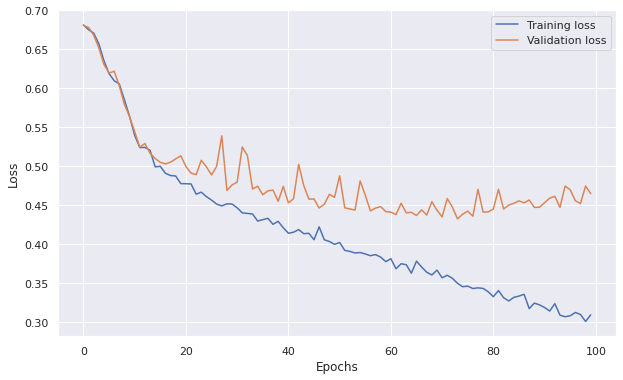

In [10]:
plt.figure(figsize = (10,6))
hist_loss = history.history['loss']
hist_val_loss = history.history['val_loss']

plt.plot(hist_loss, label='Training loss')
plt.plot(hist_val_loss, label='Validation loss')

plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

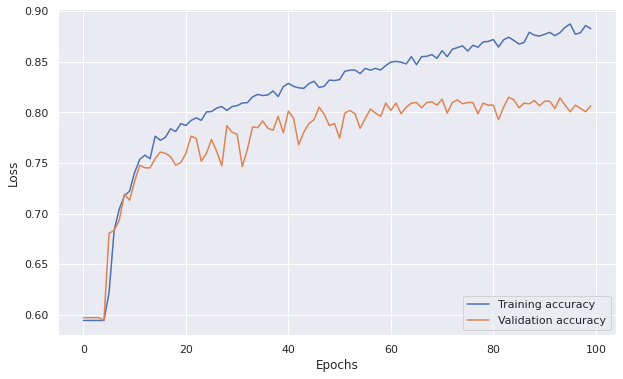

In [11]:
# visualize accuracy for the training
plt.figure(figsize = (10,6))
hist_loss = history.history['accuracy']
hist_val_loss = history.history['val_accuracy']

plt.plot(hist_loss, label='Training accuracy')
plt.plot(hist_val_loss, label='Validation accuracy')

plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

In [12]:
loss, accuracy = model.evaluate(X_valid, y_valid)

27/27 [==============================] - 2s 69ms/step - loss: 0.4856 - accuracy: 0.8077


In [13]:
model.save('final')

INFO:tensorflow:Assets written to: final/assets


In [14]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [15]:
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
